In [1]:
%cd ..

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from src.gaussian_mixture.gaussian_mixture import evaluate_case, find_best_component_number
from sklearn.cluster import MeanShift, estimate_bandwidth
from src.utils.dataset import *
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
from sklearn import metrics
import tensorflow.keras.datasets.reuters
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
import matplotlib
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
def visualize_2d(data, labels):
    ax = plt.figure(figsize=(10,10)).add_subplot(1,1,1)
    for label in np.unique(labels):
        ax.scatter(data[labels == label, 0], data[labels == label, 1], label=label, cmap='tab20')
    ax.legend()
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
def prepare_reuters_dataset():
    (sequences, target), _ = tensorflow.keras.datasets.reuters.load_data(
        num_words=1000,
        test_split=0,
        seed=113,
        start_char=1,
        oov_char=2,
        index_from=3
    )
    category_names = [
        'cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
        'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
        'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
        'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
        'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead'
    ]
    target = np.array([category_names[t] for t in target])
    categories = np.unique(target)
    categories = sorted(categories, key=lambda category: -np.sum(target == category))
    categories = categories[:5]
    print("Categories:", {cat: np.sum(target == cat) for cat in categories})
    mask = [label in categories for label in target]
    sequences = sequences[mask].copy()
    target = target[mask].copy()
    print("Total count", len(target))
    return sequences, target

sequences, target = prepare_reuters_dataset()

Categories: {'earn': 3972, 'acq': 2423, 'money-fx': 682, 'crude': 543, 'grain': 537}
Total count 8157


In [5]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_sequences(sequences)
vectors_tfidf = tokenizer.sequences_to_matrix(sequences, mode='tfidf')
vectors_tf = tokenizer.sequences_to_matrix(sequences, mode='count')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 8157 samples in 0.016s...
[t-SNE] Computed neighbors for 8157 samples in 4.246s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8157
[t-SNE] Computed conditional probabilities for sample 2000 / 8157
[t-SNE] Computed conditional probabilities for sample 3000 / 8157
[t-SNE] Computed conditional probabilities for sample 4000 / 8157
[t-SNE] Computed conditional probabilities for sample 5000 / 8157
[t-SNE] Computed conditional probabilities for sample 6000 / 8157
[t-SNE] Computed conditional probabilities for sample 7000 / 8157
[t-SNE] Computed conditional probabilities for sample 8000 / 8157
[t-SNE] Computed conditional probabilities for sample 8157 / 8157
[t-SNE] Mean sigma: 1.585687
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.550491
[t-SNE] KL divergence after 1000 iterations: 1.306723


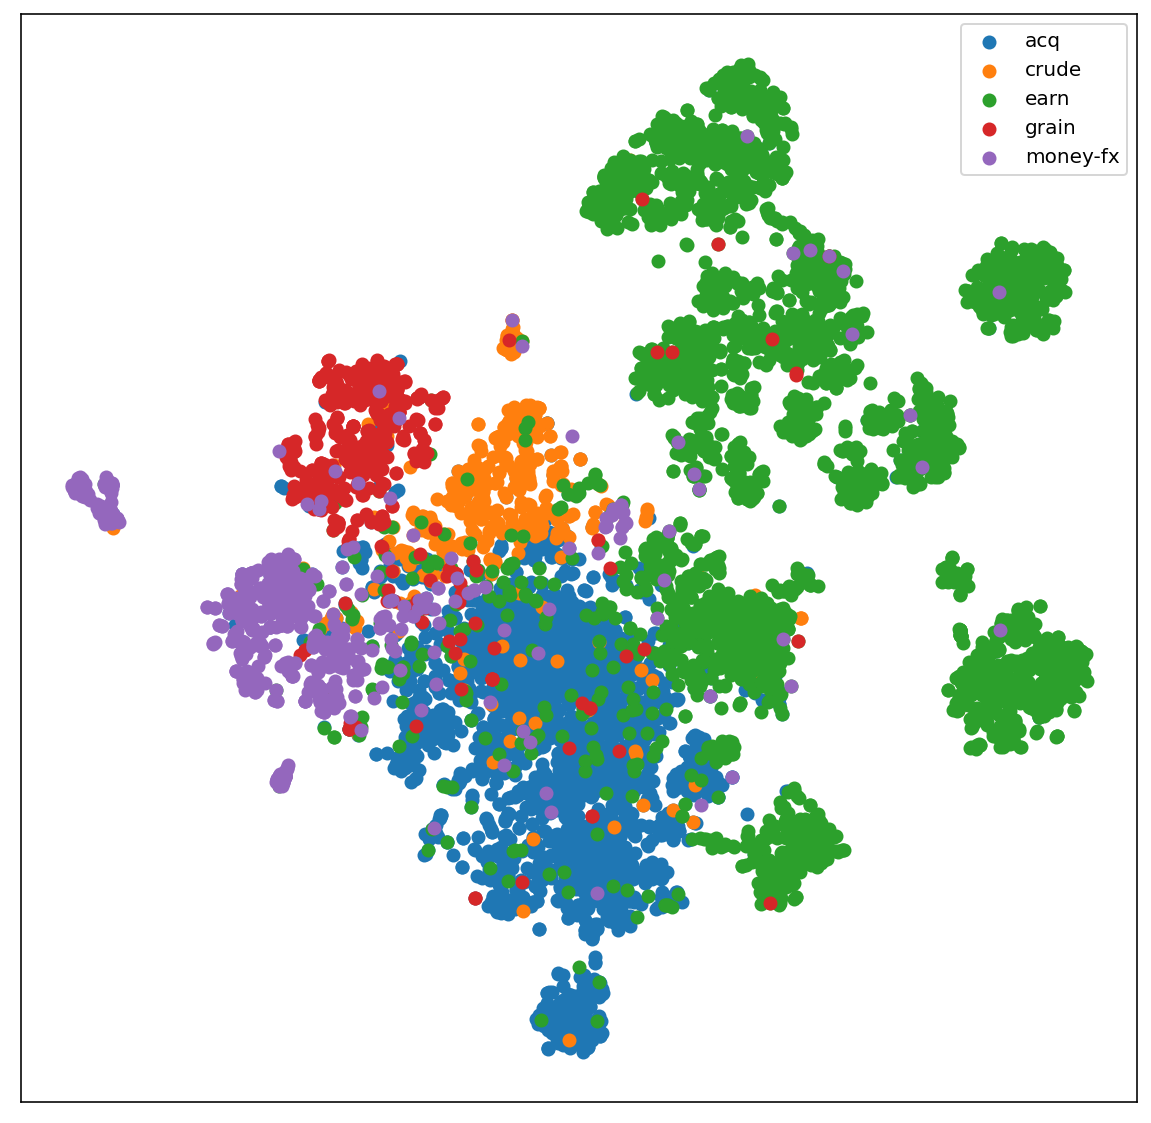

In [6]:
pca = PCA(n_components=50, random_state=13)
dim50 = pca.fit_transform(vectors_tfidf)
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200, random_state=13)
vectors_tfidf_pca_tsne = tsne.fit_transform(dim50)
visualize_2d(vectors_tfidf_pca_tsne, target)

In [7]:
def calculate_clustering_metrics(labels_true, labels_pred):
    labels_true = LabelEncoder().fit_transform(labels_true)
    
    metrics_to_evaluate_1 = {
        'c_index': concordance_index,
        'homogeneity': metrics.homogeneity_score,
        'completeness': metrics.completeness_score,
        'v_measure': metrics.v_measure_score,
        'normalized_mutual_info': metrics.normalized_mutual_info_score,
    }

    metrics_to_evaluate_2 = {
        'silhouette': metrics.silhouette_score,
        'davies_bouldin': metrics.davies_bouldin_score,
    }

    p1 = {
        metric_name: metric(labels_true, labels_pred) for
        metric_name, metric in
        metrics_to_evaluate_1.items()
    }
    p2 = {
        metric_name: metric(labels_true.reshape((-1,1)), labels_pred.reshape((-1,1))) for
        metric_name, metric in
        metrics_to_evaluate_2.items()
    }

    p1.update(p2)

    return pd.DataFrame({"value": list(p1.values())}, index=p1.keys())

### TF-IDF + GMM

/Users/pj/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/pj/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,value
c_index,0.606717
homogeneity,0.303876
completeness,0.365994
v_measure,0.332055
normalized_mutual_info,0.332055
silhouette,0.125244
davies_bouldin,10.060655


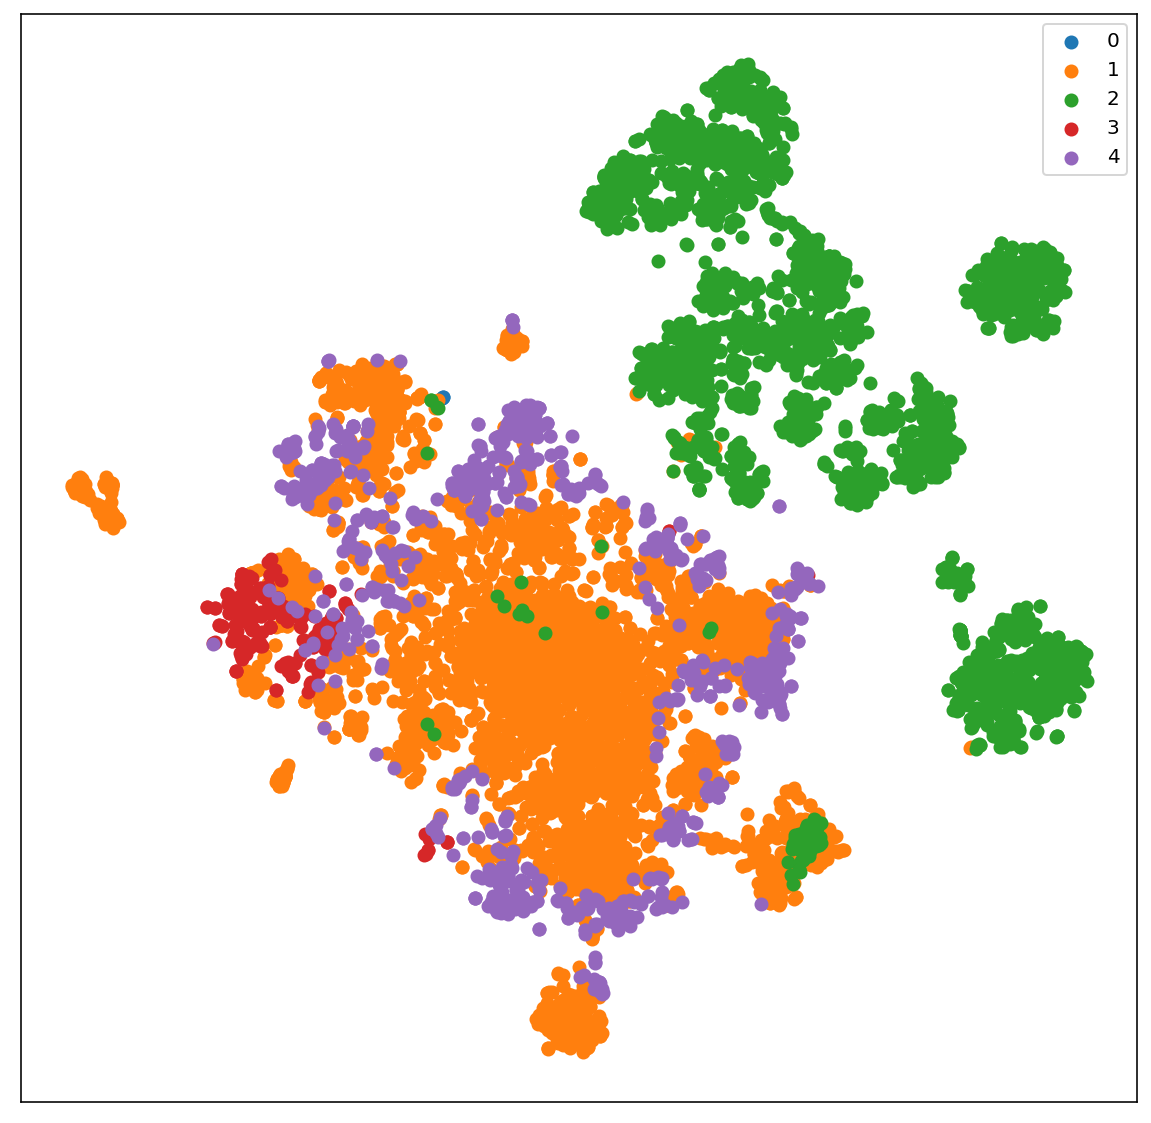

In [8]:
gm = GaussianMixture(n_components=5, random_state=13)
predicted = gm.fit_predict(vectors_tfidf)
display(calculate_clustering_metrics(target, predicted))

visualize_2d(vectors_tfidf_pca_tsne, predicted)

### TF + LDA + GMM

/Users/pj/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/pj/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,value
c_index,0.293264
homogeneity,0.397577
completeness,0.330308
v_measure,0.360834
normalized_mutual_info,0.360834
silhouette,0.124968
davies_bouldin,20.549114


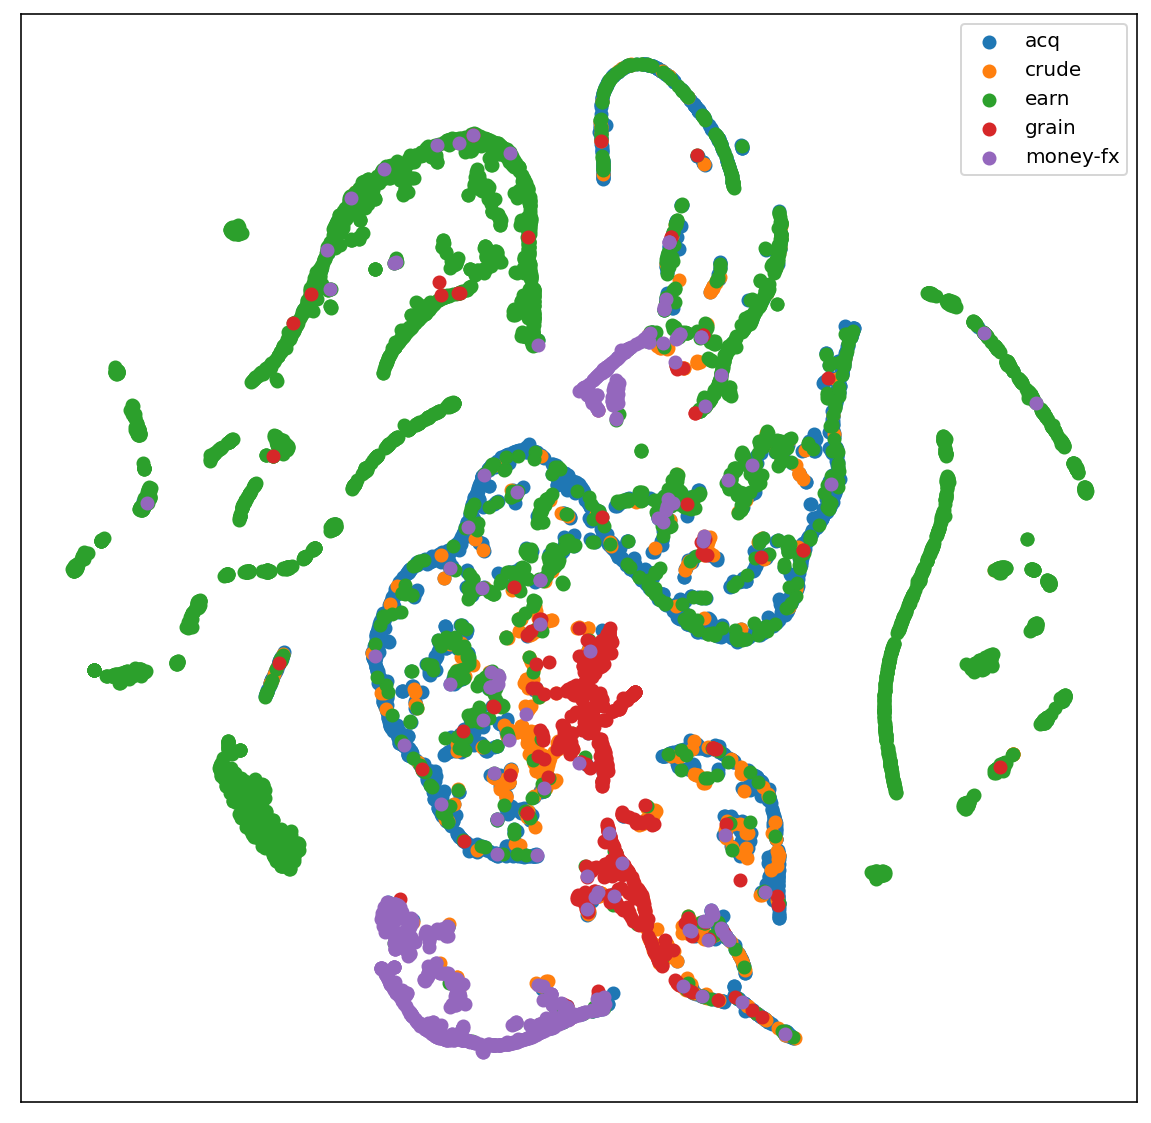

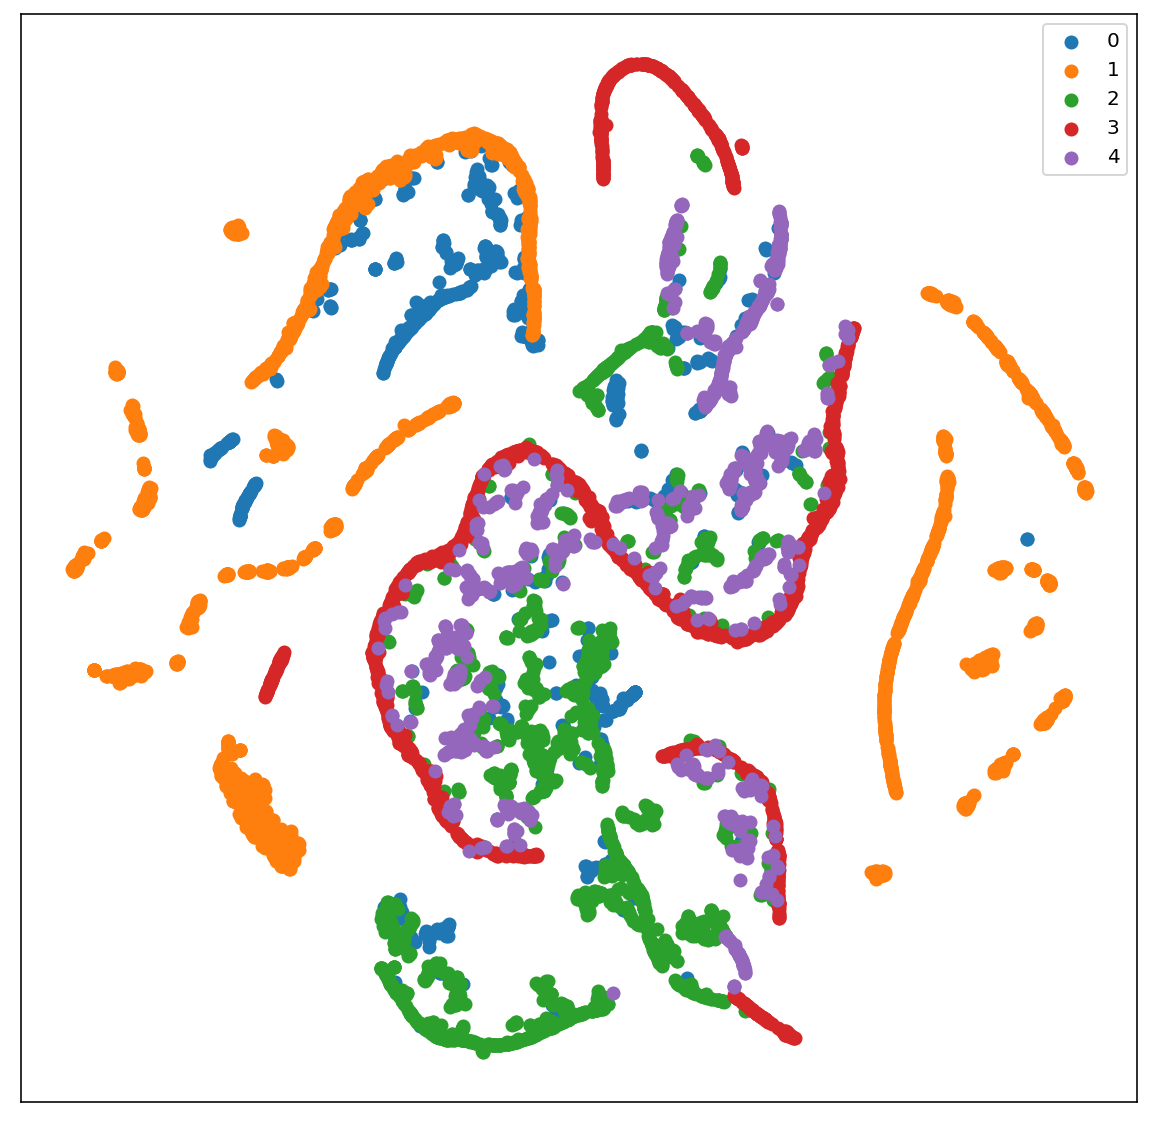

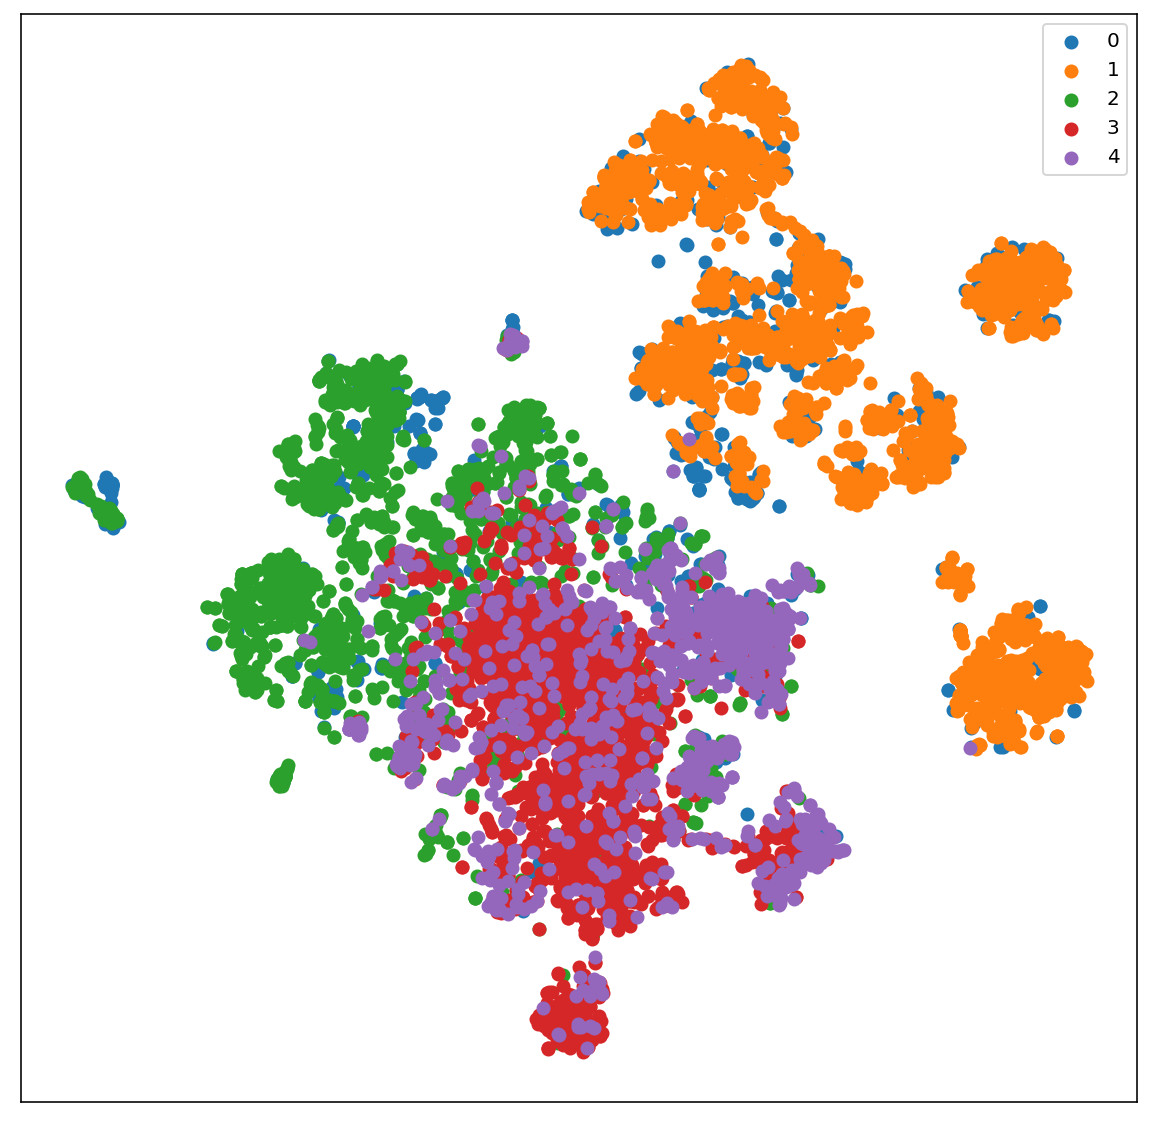

In [9]:
lda = LatentDirichletAllocation(n_components=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=13,
                                n_jobs=4)
lda.fit(vectors_tf)
vectors_lda = lda.transform(vectors_tf)

gmm = GaussianMixture(n_components=5, random_state=13)
predicted = gmm.fit_predict(vectors_lda)
display(calculate_clustering_metrics(target, predicted))

tsne = TSNE(n_components=2, random_state=13)
vectors_count_lda_tsne = tsne.fit_transform(vectors_lda)
visualize_2d(vectors_count_lda_tsne, target)
visualize_2d(vectors_count_lda_tsne, predicted)
visualize_2d(vectors_tfidf_pca_tsne, predicted)

### Doc2Vec + GMM

/Users/pj/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/pj/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,value
c_index,0.453413
homogeneity,0.219789
completeness,0.204034
v_measure,0.211618
normalized_mutual_info,0.211618
silhouette,0.007967
davies_bouldin,56.314611


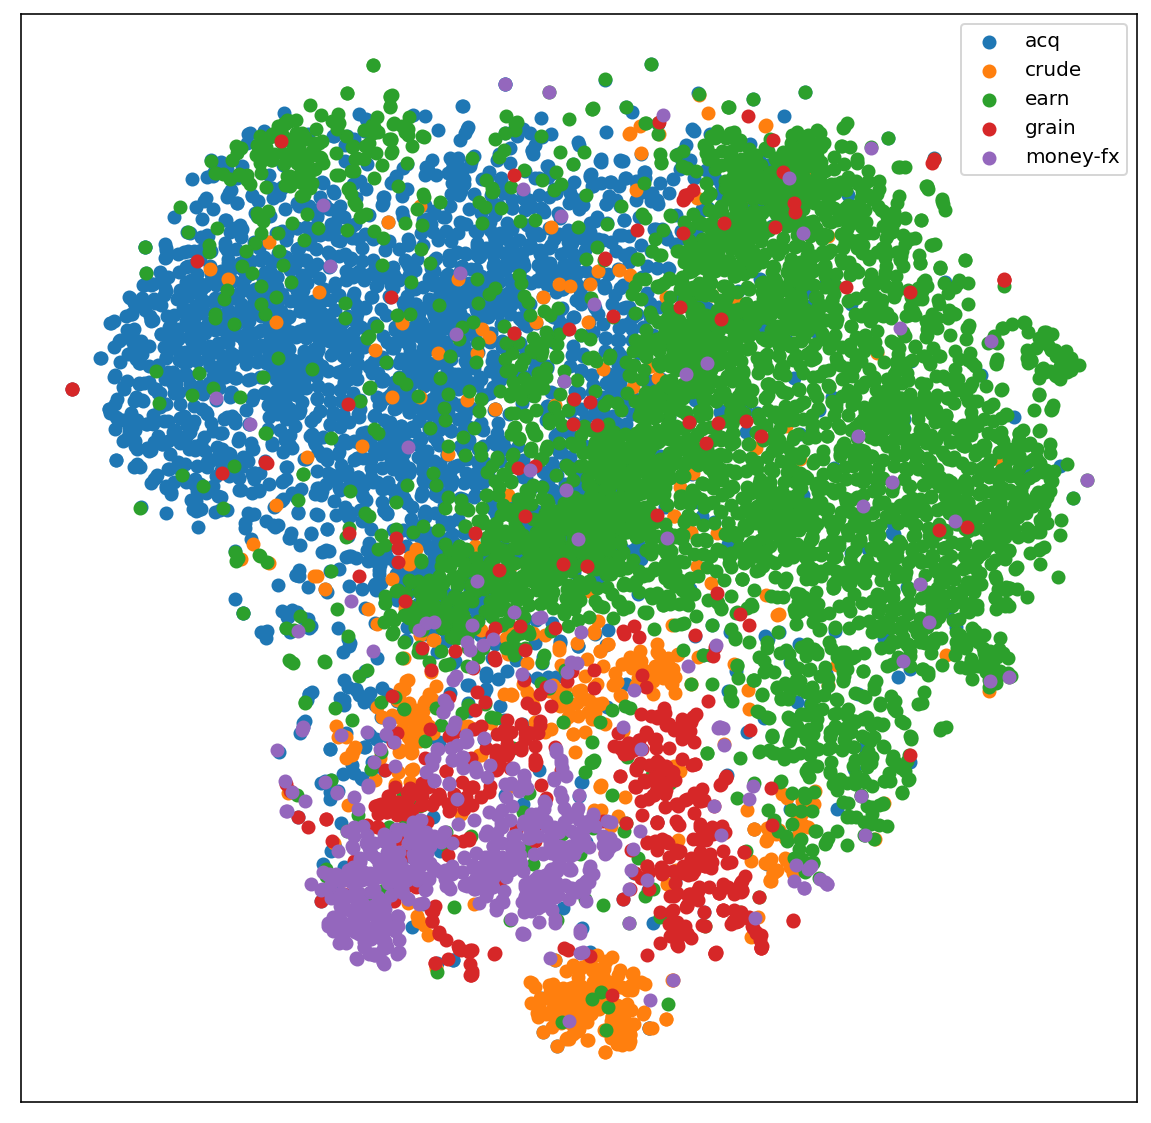

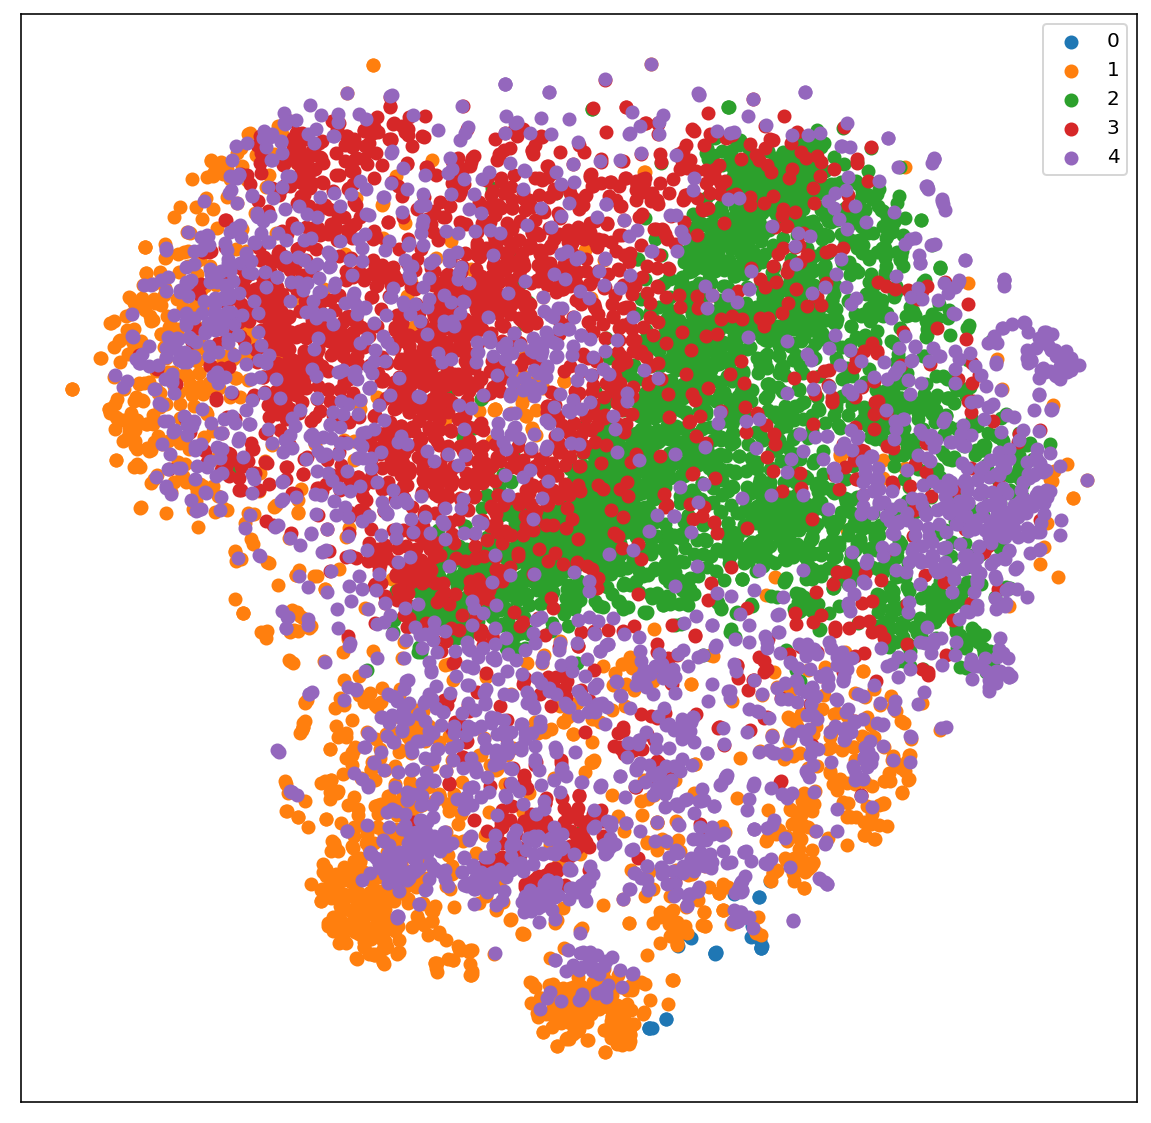

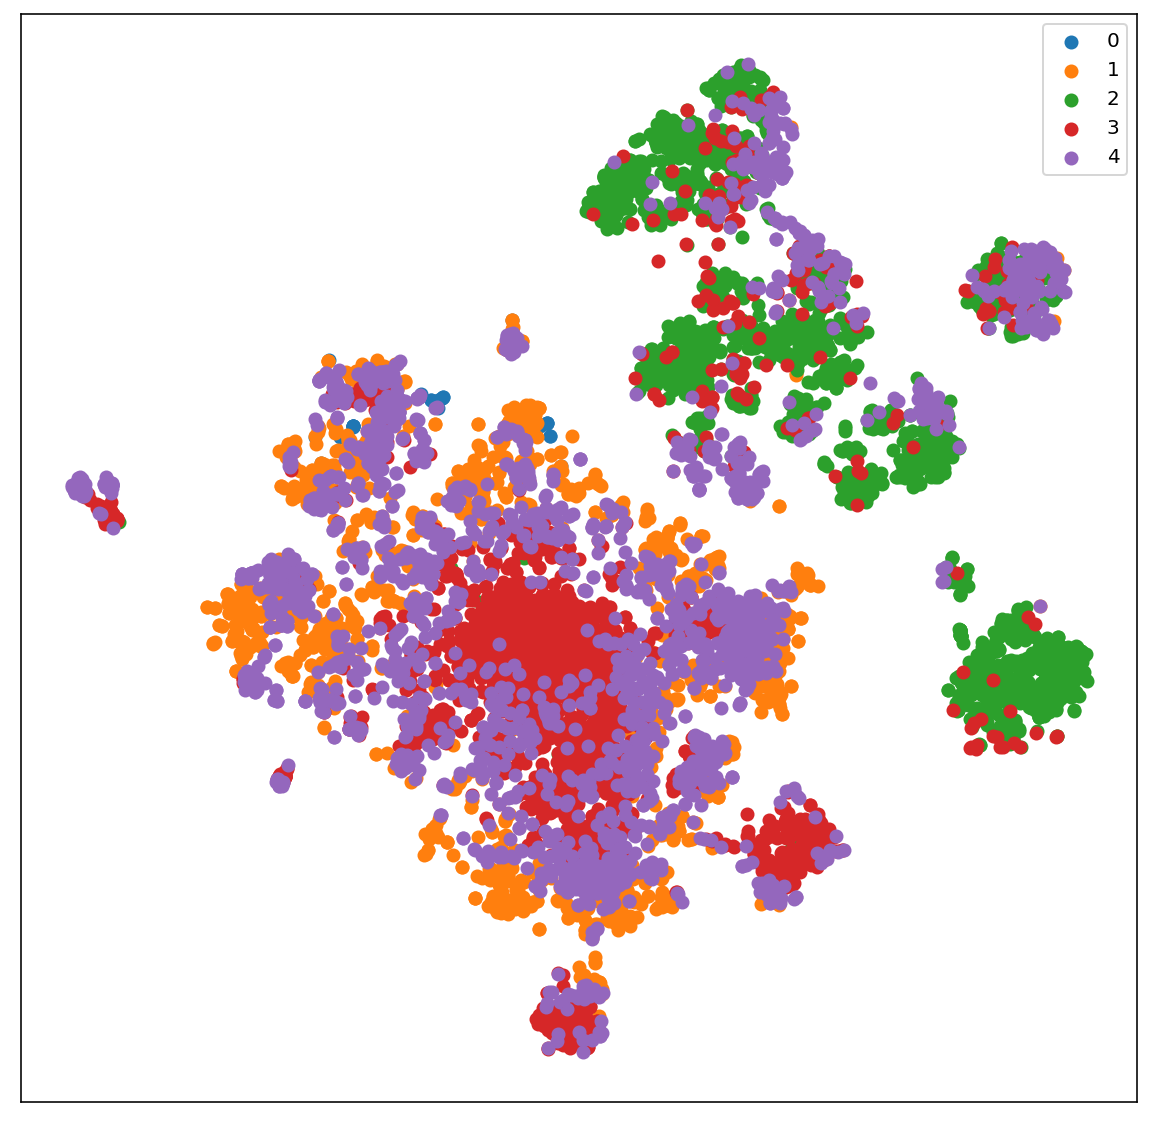

In [10]:
documents = [TaggedDocument(list(map(str, seq)), [i]) for i, seq in enumerate(sequences)]
doc2vec = Doc2Vec(documents, vector_size=50, window=2, min_count=1, workers=4)
vectors_doc2vec = np.array([doc2vec.docvecs[i] for i in range(len(sequences))])

gm = GaussianMixture(n_components=5, random_state=13)
predicted = gm.fit_predict(vectors_doc2vec)
display(calculate_clustering_metrics(target, predicted))

tsne = TSNE(n_components=2, perplexity=50, random_state=13)
vectors_doc2vec_tsne = tsne.fit_transform(vectors_doc2vec)
visualize_2d(vectors_doc2vec_tsne, target)
visualize_2d(vectors_doc2vec_tsne, predicted)
visualize_2d(vectors_tfidf_pca_tsne, predicted)